# Erzeugung von Bildunterschriften mitt einem Encoder-Decoder-Netz

Das Microsoft **C**ommon **O**bjects in **CO**ntext (MS COCO) Dataset wird normalerweise zum Training von Modellen zur Objekt- und Szenenerkennung verwendet. 

![COCO Sample Image](https://cocodataset.org/images/coco-examples.jpg)

Der Datensatz enthält unter anderem gut 200.000 Bilder mit von Menschen erzeugten Bildbeschreibungen. Diese wollen wir nutzen, um ein Encoder-Decoder-Modell zur Erzeugung von Bildbeschreibungen zu erzeugen.

Dabei kombinieren wir ein vortrainiertes **ResNeXt-Modell** als Encoder mit einem **RNN** als Decoder. 

*Hinweis: Mittlerweile gibt es mit der Transformer-Architektur sowohl auf der Encoder- als auch der Decoder-Seite eine leistungsfähigere Architektur. Dies wäre ein mögliches Thema für eine Hausarbeit. Auch der umgekehrte Weg – die Erzeugung von Bildern zu Beschreibungen mithilfe von **Strabele Diffussdion** und **CLIP** wäre ein spannendes Thema.* 

In [2]:
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-vkxtqvf8
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-vkxtqvf8
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312249 sha256=de3d37c703f43ad6decc5e23c37daefedf74698b513a06a40be07db8c9302bd8
  Stored in directory: /tmp/pip-ephem-wheel-cache-d318taw8/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [3]:
!pip install nltk gradio

import nltk
nltk.download('punkt')

  Using cached nltk-3.8-py3-none-any.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 9.5 MB/s eta 0:00:00:00:0100:01
  Using cached httpx-0.23.1-py3-none-any.whl (84 kB)
  Using cached pydantic-1.10.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.8 MB)
  Using cached fastapi-0.88.0-py3-none-any.whl (55 kB)
  Using cached markdown_it_py-2.1.0-py3-none-any.whl (84 kB)
  Using cached python_multipart-0.0.5-py3-none-any.whl
  Using cached ffmpy-0.3.0-py3-none-any.whl
  Using cached uvicorn-0.20.0-py3-none-any.whl (56 kB)
  Using cached websockets-10.4-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (106 kB)
  Using cached orjson-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (279 kB)
  Using cached pycryptodome-3.16.0-cp35-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.3 MB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Usi

[nltk_data] Downloading package punkt to /home/chgaw002/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import os
import time
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

## Laden des Datensatzes

Den Datensatz finden Sie zentral unter `/data/coco`.

In [5]:
# initialize COCO API for instance annotations
dataDir = '/data/coco'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, f'annotations/instances_{dataType}.json')
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, f'annotations/captions_{dataType}.json')
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=5.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


Die folgende Zelle lädt ein Beispielbild samt der zugehörigen Beschreibungen. 

http://images.cocodataset.org/val2014/COCO_val2014_000000063480.jpg


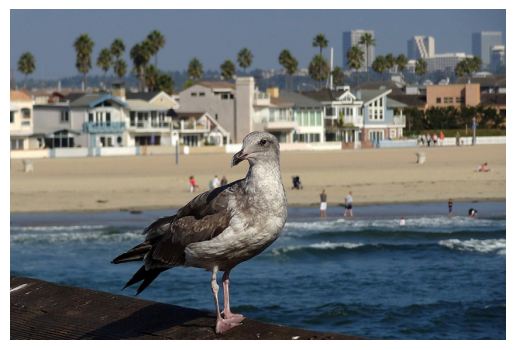

A gray and black bird sitting next to the ocean.
A pelican sits lone on a deck at the beach.
A seagull perched on a roof near the water
a white bird standing on a wooden structure next to a body of water
A bird is standing on a plank overlooking the beach.


In [6]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

## Tokenisierung und Vektorisierung der Texte

Wir erstellen ein Vokabular für die Beschreibungen und fügen dabei drei spezielle Token ein:

- `<start>` als Markierung für den Start des Textes,
- `<end>` als Markierung für das Ende des Textes,
- `<pad>` als Füllzeichen (*Padding*),
- `<unk>` als Markierung für unbekannte Worte.

In [7]:
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file="./vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        pad_word="<pad>",
        vocab_from_file=False,
        coco_annotations_file="/data/coco/annotations/captions_train2014.json"):
      
        """Initialize the vocabulary.
        Paramters:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any
                           existing vocab_file. If True, load vocab from from
                           existing vocab_file, if it exists.
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.coco_annotations_file = coco_annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file or build it from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print("Vocabulary successfully loaded from vocab.pkl file!")
        else:
            print("Building vocabulary: {}, {}".format(os.path.exists(self.vocab_file), self.vocab_from_file))
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers 
        (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.pad_word)
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers
        (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary 
        that meet or exceed the threshold."""
        coco = COCO(self.coco_annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(tqdm(ids, desc="tokenizing captions")):
            caption = str(coco.anns[id]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, cnt in counter.items()
                 if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

## Erstellen eines `Dataset`

Die folgende Klasse kapselt den COCO Datensatz als PyTorch Dataset.

In [8]:
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm.notebook import tqdm
import random
import json

class CocoDataset(data.Dataset):

    coco_paths = { "train": [ "/data/coco/annotations/captions_train2014.json", "/data/coco/images/train2014/" ],
                   "val":  [ "/data/coco/annotations/captions_val2014.json", "/data/coco/images/val2014/" ],
                   "test": [ "/data/coco/annotations/image_info_test2014.json", "/data/coco/images/test2014/" ]
                 } 

    def __init__(self, transform, mode, batch_size, vocabulary):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = vocabulary
        self.coco_annotations_file = self.coco_paths[mode][0]
        self.coco_img_folder = self.coco_paths[mode][1]

        if self.mode == "train":
            self.coco = COCO(self.coco_annotations_file)
            self.coco_ids = list(self.coco.anns.keys())
              
            print("Obtaining caption lengths...")
            coco_tokens = [nltk.tokenize.word_tokenize(
                          str(self.coco.anns[self.coco_ids[index]]["caption"]).lower())
                            for index in tqdm(np.arange(len(self.coco_ids)))]
 
            self.caption_lengths = [len(token) for token in coco_tokens]
            self.max_length = max(self.caption_lengths)

        elif self.mode == "val":
            self.coco = COCO(self.coco_annotations_file)
            self.coco_ids = list(self.coco.imgs.keys())
 
        
    def __getitem__(self, index):
        # Obtain image and caption if in training or validation mode
        if self.mode == "train":
            ann_id = self.coco_ids[index]
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"]
            path = self.coco.loadImgs(img_id)[0]["file_name"]
            image = Image.open(os.path.join(self.coco_img_folder, path)).convert("RGB")

            # Convert image to tensor and pre-process using transform
            
            image = self.transform(image)

            orig = caption

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            length = len(caption)
            for i in range(len(caption), self.max_length+2):
                caption.append(self.vocab(self.vocab.pad_word))
            caption = torch.Tensor(caption).long()

            # Return pre-processed image and caption tensors
            return image, caption, length, ann_id

        elif self.mode == "val":
            img_id = self.coco_ids[index]
            path = self.coco.loadImgs(img_id)[0]["file_name"]
            image = Image.open(os.path.join(self.coco_img_folder, path)).convert("RGB")
            image = self.transform(image)

            return image, torch.empty(1), torch.empty(1), img_id

 
    def __len__(self):
        return len(self.coco_ids)

In [9]:
class MyDataLoader(data.DataLoader):
    vocab = None

    def __init__(self,
                transform,
               mode="train",
               batch_size=1,
               vocab_threshold=None,
               vocab_file="./vocab.pkl",
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               pad_word="<pad>",
               vocab_from_file=True,
               num_workers=0):
        """Return the data loader.
        Parameters:
        transform: Image transform.
        mode: One of "train", "val" or "test".
        batch_size: Batch size (if in testing mode, must have batch_size=1).
        vocab_threshold: Minimum word count threshold.
        vocab_file: File containing the vocabulary. 
        start_word: Special word denoting sentence start.
        end_word: Special word denoting sentence end.
        unk_word: Special word denoting unknown words.
        vocab_from_file: If False, create vocab from scratch & override any 
                         existing vocab_file. If True, load vocab from from
                         existing vocab_file, if it exists.
        num_workers: Number of subprocesses to use for data loading 
        cocoapi_loc: The location of the folder containing the COCO API: 
                     https://github.com/cocodataset/cocoapi
        """
    
        assert mode in ["train", "val", "test"], "mode must be one of 'train', 'val' or 'test'."

        if self.vocab is None:
            if vocab_from_file == False: 
                assert mode == "train", "To generate vocab from captions file, must be in training mode (mode='train')."
            self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
                                    end_word, unk_word, pad_word, vocab_from_file)
     
        # COCO caption dataset
        self.coco_dataset = CocoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocabulary=self.vocab)

        if mode == "train":
            # Calculating overall maximum of caption length (needed for padding)
            print(f"Maximum caption length: {self.coco_dataset.max_length}")
            
 
        dataset = self.coco_dataset
        super().__init__(dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)


In [10]:
import torch
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
train_loader = MyDataLoader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         num_workers=10,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

transform_val = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

val_loader = MyDataLoader(transform=transform_val,
                        mode='val',
                        batch_size=batch_size,
                        num_workers=5,
                        vocab_threshold=vocab_threshold,
                        vocab_from_file=True)

Building vocabulary: True, False
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


tokenizing captions:   0%|          | 0/414113 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Obtaining caption lengths...


  0%|          | 0/414113 [00:00<?, ?it/s]

Maximum caption length: 57
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


## Trainer

Die folgende Klasse kapselt den Training- und Evaluationsprozess.

In [11]:
class Trainer:
    """The Trainer encapsulates the model training process."""

    def __init__(self, train_loader, val_loader, encoder, decoder, optimizer, criterion=None, start_epoch=0, rounds=1):
        """Initialize the Trainer state. This includes loading the model data if start_epoch > 0."""
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.encoder = encoder
        self.decoder = decoder
        self.epoch = start_epoch
        self.rounds = rounds
        self.current_state_file = os.path.join('./models', 'current-model.pkl')
        self.optimizer = optimizer
        self.vocab = self.train_loader.vocab
        self.vocab_size = len(self.vocab)
        if criterion is None:
            pad_idx = self.vocab.word2idx['<pad>']
            self.criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
        else: 
            self.criterion = criterion
        
        if torch.cuda.is_available():
            self.map_location = torch.device('cuda')
            self.criterion.cuda()
            self.encoder.cuda()
            self.decoder.cuda()
        else:
            self.map_location = torch.device('cpu')

        self.cider = []

        if self.epoch > 0:
            self.load()
    
    def load(self):
        """Load the model output of an epoch."""
        checkpoint = torch.load(self.current_state_file, map_location=self.map_location)

        # Load the pre-trained weights
        self.encoder.load_state_dict(checkpoint['encoder'])
        self.decoder.load_state_dict(checkpoint['decoder'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epoch = checkpoint['epoch']
        self.cider = checkpoint['cider']
        print('Successfully loaded epoch {}'.format(self.epoch))

    def save_as(self, file_name):
        """Save the training state in a pickle file.
        The following values are saved: 
        - encoder parameter, 
        - decoder parameters,
        - optimizer state, 
        - current epoch,
        - list of CIDEr scores from the evaluation of past epochs.
        
        Parameters
        ----------
        file_name : str
            Name of the file to save.
        """
        torch.save({"encoder": self.encoder.state_dict(),
                    "decoder": self.decoder.state_dict(),
                    "optimizer": self.optimizer.state_dict(),
                    "cider": self.cider,
                    "epoch": self.epoch
                   }, file_name)

    def save(self):
        """Save the training state in a pickle file.
        
        The following values are saved: 
        - encoder parameter, 
        - decoder parameters,
        - optimizer state, 
        - current epoch,
        - list of CIDEr scores from the evaluation of past epochs.
        """
        self.save_as(os.path.join("./models", "current-model.pkl"))
        self.save_as(os.path.join("./models", "epoch-model-{}.pkl".format(self.epoch)))

    def clean_sentence(self, word_idx_list):
        """Take a list of word ids and a vocabulary from a dataset as inputs
        and return the corresponding sentence as a single Python string.
        Parameters
        ----------
        word_idx_list : list
            List of word indices, i.e. embedded words.
        """
        sentence = []
        for i in range(len(word_idx_list)):
            vocab_id = word_idx_list[i]
            word = self.vocab.idx2word[vocab_id]
            if word == self.vocab.end_word:
                break
            if word != self.vocab.start_word:
                sentence.append(word)
        sentence = " ".join(sentence)
        return sentence

    def train(self):
        """Train the model for one epoch using the provided parameters. Return the epoch's average train loss."""

        # Switch to train mode
        self.encoder.train()
        self.decoder.train()

        # Keep track of train loss
        total_loss = 0

        # Start time for every 100 steps
        start_train_time = time.time()
        i_step = 0
    
        # Obtain the batch
        pbar = tqdm(self.train_loader)
        pbar.set_description('training epoch {}'.format(self.epoch))
        for batch in pbar:
            i_step += 1
            images, captions, lengths = batch[0], batch[1], batch[2]
             
            # Move to GPU if CUDA is available
            if torch.cuda.is_available():
                images = images.cuda()
                captions = captions.cuda()
                lengths = lengths.cuda()

            # Pass the inputs through the CNN-RNN model
            features = self.encoder(images)
            outputs = self.decoder(features, captions, lengths)

            # Calculate the batch loss
            # Flatten batch dimension
            outputs = outputs.view(-1, vocab_size)
            captions = captions.view(-1)

            loss = self.criterion(outputs, captions)

            # Zero the gradients. Since the backward() function accumulates 
            # gradients, and we don’t want to mix up gradients between minibatches,
            # we have to zero them out at the start of a new minibatch
            self.optimizer.zero_grad()
            # Backward pass to calculate the weight gradients
            loss.backward()
            # Update the parameters in the optimizer
            self.optimizer.step()

            total_loss += loss.item()

            pbar.set_postfix(last=loss.item(), avg=total_loss/i_step)
            
        self.epoch += 1
        self.save()

        return total_loss / i_step

    def evaluate(self):
        """Evaluate the model for one epoch using the provided parameters. 
           Return the epoch's average CIDEr score."""

        # Switch to validation mode
        self.encoder.eval()
        self.decoder.eval()

        cocoRes = COCO()
        anns = []

        # Disable gradient calculation because we are in inference mode
        with torch.no_grad():
            pbar = tqdm(self.val_loader)
            pbar.set_description('evaluating epoch {}'.format(self.epoch));
            for batch in pbar:
                images, img_id = batch[0], batch[3]

                # Move to GPU if CUDA is available
                if torch.cuda.is_available():
                    images = images.cuda()

                # Pass the inputs through the CNN-RNN model
                features = encoder(images).unsqueeze(1)
                for i in range(img_id.size()[0]):
                    slice = features[i].unsqueeze(0)
                    outputs = decoder.sample_beam_search(slice)
                    sentence = self.clean_sentence(outputs[0])
                    id = img_id[i].item()
                    #print('id: {}, cap: {}'.format(id, sentence))
                    anns.append({'image_id': id, 'caption': sentence})
             
        for id, ann in enumerate(anns):
            ann['id'] = id
    
        cocoRes.dataset['annotations'] = anns
        cocoRes.createIndex()

        cocoEval = COCOEvalCap(self.val_loader.coco_dataset.coco, cocoRes)
        imgIds = set([ann['image_id'] for ann in cocoRes.dataset['annotations']])
        cocoEval.params['image_id'] = imgIds
        cocoEval.evaluate()
        cider = cocoEval.eval['CIDEr']
        old_max = 0
        if len(self.cider) > 0:
            old_max = max(self.cider)

        if len(self.cider) < self.epoch:
            self.cider.append(cider)
        else:
            self.cider[self.epoch-1] = cider
        self.save()
        print("DEBUG: self.epoch: {}, self.cider: {}".format(self.epoch, self.cider))
        if cider > old_max:
            print('CIDEr improved: {:.2f} => {:.2f}'.format(old_max, cider))
            self.save_as(os.path.join("./models", "best-model.pkl"))

        return self.cider[self.epoch-1]


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.nn import functional as F


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.DEFAULT)
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        features = self.bn(features)
        return features


class DecoderRNN(nn.Module):
    """Decoder RNN based on 2-layer GRU model."""
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.3):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        # Store length of the padded captions - we need it re-pad the packed output sequences 
        total_length = captions.size(1)
        
        # The following line should have the effect that the "stop word" is not presented during training.
        # However, it leads to degraded performance ...
        # reduced_lengths = torch.add(lengths, -1)
        reduced_lengths = lengths
        embeddings = self.embed(captions)

        # This means that the image is presented to the RNN only in step 1
        # TODO: Check if it would be better to include the image in *every* input
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)

        # pack padded input sequences
        inputs = torch.nn.utils.rnn.pack_padded_sequence(inputs, reduced_lengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = self.gru(inputs)
        # pad sequences again using the stored length of the padded captions
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, total_length=total_length)
        outputs = self.linear(x)

        return outputs

    def sample(self, inputs, states=None, max_len=20):
        """Accept a pre-processed image tensor (inputs) and return predicted 
        sentence (list of tensor ids of length max_len). This is the greedy
        search approach.
        """
        sampled_ids = []
        for i in range(max_len):
            hiddens, states = self.gru(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            # Get the index (in the vocabulary) of the most likely integer that
            # represents a word
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted.item())
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        return sampled_ids

    def sample_beam_search(self, inputs, states=None, max_len=20, beam_width=5):
        """Accept a pre-processed image tensor and return the top predicted 
        sentences. This is the beam search approach.
        """
        # Top word idx sequences and their corresponding inputs and states
        idx_sequences = [[[], 0.0, inputs, states]]
        for _ in range(max_len):
            # Store all the potential candidates at each step
            all_candidates = []
            # Predict the next word idx for each of the top sequences
            for idx_seq in idx_sequences:
                hiddens, states = self.gru(idx_seq[2], idx_seq[3])
                outputs = self.linear(hiddens.squeeze(1))
                # Transform outputs to log probabilities to avoid floating-point 
                # underflow caused by multiplying very small probabilities
                log_probs = F.log_softmax(outputs, -1)
                top_log_probs, top_idx = log_probs.topk(beam_width, 1)
                top_idx = top_idx.squeeze(0)
                # create a new set of top sentences for next round
                for i in range(beam_width):
                    next_idx_seq, log_prob = idx_seq[0][:], idx_seq[1]
                    next_idx_seq.append(top_idx[i].item())
                    log_prob += top_log_probs[0][i].item()
                    # Indexing 1-dimensional top_idx gives 0-dimensional tensors.
                    # We have to expand dimensions before embedding them
                    inputs = self.embed(top_idx[i].unsqueeze(0)).unsqueeze(0)
                    all_candidates.append([next_idx_seq, log_prob, inputs, states])
            # Keep only the top sequences according to their total log probability
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            idx_sequences = ordered[:beam_width]
        return [idx_seq[0] for idx_seq in idx_sequences]


In [13]:
# Set values for the training variables
batch_size = 512        # batch size
vocab_threshold = 5     # minimum word count threshold
vocab_from_file = True  # if True, load existing vocab file
embed_size = 512        # dimensionality of image and word embeddings
hidden_size = 512       # number of features in hidden state of the RNN decoder
num_epochs = 10         # number of training epochs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The size of the vocabulary
vocab_size = len(train_loader.vocab)

# Initialize the encoder and decoder
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

# Specify the learnable parameters of the model
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters()) + list(encoder.resnet.parameters())

# Define the optimizer
optimizer = torch.optim.AdamW(params=params, lr=0.001, weight_decay=0.05, amsgrad=True)

trainer = Trainer(train_loader, val_loader, encoder, decoder, optimizer)

In [14]:
if not os.path.exists(trainer.current_state_file):
    trainer.train()
trainer.load()

Successfully loaded epoch 11


In [21]:
# if cider is missing for current epoch, evaluater first
if len(trainer.cider) < trainer.epoch:
    print('Epoch {} not yet evaluated'.format(trainer.epoch))
    trainer.evaluate()

for i in range(num_epochs):
    trainer.train()
    trainer.evaluate()

Successfully loaded epoch 11


  0%|          | 0/41412 [00:00<?, ?it/s]

KeyboardInterrupt: 

http://images.cocodataset.org/val2014/COCO_val2014_000000423618.jpg


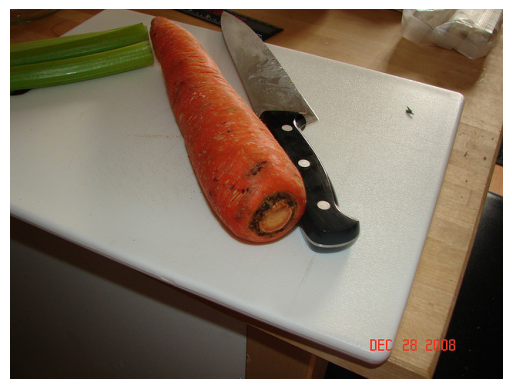

a cutting board topped with a knife on a cutting board .
a cutting board topped with a knife on a cutting board .
a cutting board topped with a knife on a cutting board .
a cutting board topped with a knife on a cutting board .
a cutting board topped with a knife on a cutting board .


In [17]:
for imgs, _, _, img_ids in val_loader:
    break
    
imgs = imgs[0].unsqueeze(0).to(device)

img_id = img_ids[0].item()
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# Calculate features

vocab = val_loader.vocab

encoder.eval()
decoder.eval()

with torch.no_grad():
    features = encoder(imgs).unsqueeze(1)

# Generate caption with decoder.sample

### YOUR CODE HERE
output = decoder.sample_beam_search(features)

for word_idx_list in output:
    sentence = []
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
        if word == vocab.end_word:
            break
        if word != vocab.start_word:
            sentence.append(word)
    sentence = " ".join(sentence)
    print(sentence)

In [15]:
transform = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

def getCaption(img):
    vocab = val_loader.vocab

    encoder.eval()
    decoder.eval()

    img = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        features = encoder(img).unsqueeze(1)

    output = decoder.sample_beam_search(features)

    for word_idx_list in output:
        sentence = []
        for i in range(len(word_idx_list)):
            vocab_id = word_idx_list[i]
            word = vocab.idx2word[vocab_id]
            if word == vocab.end_word:
                break
            if word != vocab.start_word:
                sentence.append(word)
        sentence = " ".join(sentence)
        print(sentence)
        
    return sentence

In [ ]:
import gradio as gr

iface = gr.Interface(getCaption, gr.Image(type="pil"), "text").launch(share=True, debug=True)

Running on local URL:  http://127.0.0.1:7860

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.
Running on public URL: https://54dfe925-9cf7-4a61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


a bird perched on a branch of a tree .
a bird perched on a branch of a tree .
a bird perched on a branch of a tree .
a bird perched on a branch of a tree .
a bird perched on a branch of a tree .
a view of a bridge over a river .
a view of a bridge over a river .
a view of a bridge over a river .
a view of a bridge over a river .
a view of a bridge over a river .
a man in a suit and tie standing in front of a wall .
a man in a suit and tie standing in front of a wall .
an image of a man that is wearing a suit
a man in a suit and tie standing in front of a wall .
a man in a suit and tie standing in front of a microphone .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a stack of suitcases sitting on top of a wooden floor .
a stack of suitcases sitting on top of a wooden floor .
a stack of suitcases sitting on top